# Prep Data Files

This needs at least 128 GB of RAM.


Nick Kern

Sept, 2020

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
import glob
import hera_pspec as hp
import hera_cal as hc
from pyuvdata import UVBeam, UVData, UVCal, UVFlag, utils as uvutils
from memory_profiler import memory_usage
import copy
import matplotlib.gridspec as gridspec
from scipy import interpolate
import uvtools as uvt
import os
import sys
import yaml
import warnings
warnings.filterwarnings('ignore', message='LST values stored in*')
warnings.filterwarnings('ignore', message='antenna_diameters is not set. Using known values for HERA.')
warnings.filterwarnings('ignore', message='Telescope RIMEz calculation is not in known_telescopes.')

/lustre/aoc/projects/hera/nkern/Software/hera_sim/hera_sim/visibilities/__init__.py:27: UserWarning: PRISim failed to import.
  warnings.warn("PRISim failed to import.")
/lustre/aoc/projects/hera/nkern/Software/hera_sim/hera_sim/visibilities/__init__.py:33: UserWarning: VisGPU failed to import.
  warnings.warn("VisGPU failed to import.")
/lustre/aoc/projects/hera/nkern/Software/hera_sim/hera_sim/__init__.py:36: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
noise.HERA_BEAM_POLY
sigchain.HERA_NRAO_BANDPASS
rfi.HERA_RFI_STATIONS

Additionally, the next major release will involve modifications to the package's API, which move toward a regularization of the way in which hera_sim methods are interfaced with; in particular, changes will be made such that the Simulator class is the most i

In [2]:
# add hera-validation tools to path
sys.path.append('/lustre/aoc/projects/hera/Validation/test-4.0.0/hera_software/hera-validation/test-series/4')
import tools

## prep true eor

In [3]:
# get LSTbinned data files
dfiles = sorted(glob.glob("/lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/sum/"
                          "zen.grp1.of1.LST.*.HH.OCRSL.uvh5"))

In [3]:
# LSTbinned metadata
uvd = UVData()
uvd.read(dfiles[0], read_data=False)

uvd_antp, uvd_ants = uvd.get_ENU_antpos()
uvd_antpd = dict(zip(uvd_ants, uvd_antp))
uvd_bls = uvd.get_antpairs()
uvd_blvecs = np.array([uvd_antpd[bl[1]] - uvd_antpd[bl[0]] for bl in uvd_bls])[:, :]

antenna_diameters is not set. Using known values for HERA.
LST values stored in /lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/sum/zen.grp1.of1.LST.0.28190.HH.OCRSL.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.


In [7]:
# get eor data files
efiles = sorted(glob.glob("/lustre/aoc/projects/hera/Validation/test-4.0.0/data/visibilities/2458098/"
                          "zen.*.eor.true.uvh5"))

In [6]:
# read eor data
eor = UVData()
eor.read(efiles[0], read_data=False)

eor_antp, eor_ants = eor.get_ENU_antpos()
eor_antpd = dict(zip(eor_ants, eor_antp))
eor_bls = eor.get_antpairs()
eor_blvecs = np.array([eor_antpd[bl[1]] - eor_antpd[bl[0]] for bl in eor_bls])[:, :]
eor_blvec_dict = dict(zip(eor_bls, eor_blvecs))

Telescope RIMEz calculation is not in known_telescopes.


In [7]:
# get uvd2eor dictionary
uvd2eor = {}
for i, bl in enumerate(uvd_bls):
    distance = np.min([np.linalg.norm(eor_blvecs - uvd_blvecs[i], axis=1),
                       np.linalg.norm(eor_blvecs + uvd_blvecs[i], axis=1)], axis=0)
    if distance.min() < 1:
        match = np.argmin(distance)
        uvd2eor[bl] = eor_bls[match]

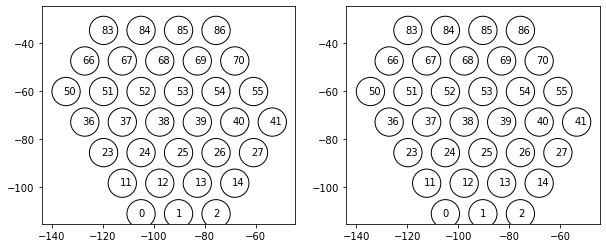

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
for i, a in enumerate(eor_ants):
    ax.scatter(eor_antp[i,0], eor_antp[i,1], s=800, fc='None', ec='k')
    ax.text(eor_antp[i,0]-1, eor_antp[i,1]-1, a)
    
ax = axes[1]
for i, a in enumerate(uvd_ants):
    ax.scatter(uvd_antp[i,0], uvd_antp[i,1], s=800, fc='None', ec='k')
    ax.text(uvd_antp[i,0]-1, uvd_antp[i,1]-1, a)

In [ ]:
# read eor file
eor.read(efiles, polarizations=[-5, -6])

In [9]:
eor_lsts = np.unique(eor.lst_array)

In [15]:
# iterate over LST binned files
for df in dfiles:
    # load dfile
    basename = os.path.basename(df)
    uvd = UVData()
    uvd.read(df, read_data=True)
    
    # get nearest LST neighbor from EoR
    uvd_lsts = np.unique(uvd.lst_array)
    eor_tinds = [np.argmin(np.abs(eor_lsts - l)) for l in uvd_lsts]
    
    # populate uvd
    for bl in uvd.get_antpairs():
        bltinds = uvd.antpair2ind(bl)
        uvd.data_array[bltinds, 0, :, :] = eor.get_data(bl)[eor_tinds]
        
    # write
    fname = "data/{}".format(basename.replace("grp1.of1", "eor").replace(".OCRSL", ""))
    print("writing {}".format(fname))
    uvd.write_uvh5(fname, clobber=True)

antenna_diameters is not set. Using known values for HERA.
LST values stored in /lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/sum/zen.grp1.of1.LST.0.28190.HH.OCRSL.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.


writing data/zen.eor.LST.0.28190.HH.uvh5


antenna_diameters is not set. Using known values for HERA.
LST values stored in /lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/sum/zen.grp1.of1.LST.0.37586.HH.OCRSL.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.


writing data/zen.eor.LST.0.37586.HH.uvh5


antenna_diameters is not set. Using known values for HERA.
LST values stored in /lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/sum/zen.grp1.of1.LST.0.46983.HH.OCRSL.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.


writing data/zen.eor.LST.0.46983.HH.uvh5


antenna_diameters is not set. Using known values for HERA.
LST values stored in /lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/sum/zen.grp1.of1.LST.0.56380.HH.OCRSL.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.


writing data/zen.eor.LST.0.56380.HH.uvh5


antenna_diameters is not set. Using known values for HERA.
LST values stored in /lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/sum/zen.grp1.of1.LST.0.65776.HH.OCRSL.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.


writing data/zen.eor.LST.0.65776.HH.uvh5


antenna_diameters is not set. Using known values for HERA.
LST values stored in /lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/sum/zen.grp1.of1.LST.0.75173.HH.OCRSL.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.


writing data/zen.eor.LST.0.75173.HH.uvh5


antenna_diameters is not set. Using known values for HERA.
LST values stored in /lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/sum/zen.grp1.of1.LST.0.84569.HH.OCRSL.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.


writing data/zen.eor.LST.0.84569.HH.uvh5


antenna_diameters is not set. Using known values for HERA.
LST values stored in /lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/sum/zen.grp1.of1.LST.0.93966.HH.OCRSL.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.


writing data/zen.eor.LST.0.93966.HH.uvh5


antenna_diameters is not set. Using known values for HERA.
LST values stored in /lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/sum/zen.grp1.of1.LST.1.03362.HH.OCRSL.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.


writing data/zen.eor.LST.1.03362.HH.uvh5


antenna_diameters is not set. Using known values for HERA.
LST values stored in /lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/sum/zen.grp1.of1.LST.1.12759.HH.OCRSL.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.


writing data/zen.eor.LST.1.12759.HH.uvh5


antenna_diameters is not set. Using known values for HERA.


writing data/zen.eor.LST.1.22156.HH.uvh5


antenna_diameters is not set. Using known values for HERA.


writing data/zen.eor.LST.1.31552.HH.uvh5


antenna_diameters is not set. Using known values for HERA.


writing data/zen.eor.LST.1.40949.HH.uvh5


antenna_diameters is not set. Using known values for HERA.


writing data/zen.eor.LST.1.50345.HH.uvh5


antenna_diameters is not set. Using known values for HERA.


writing data/zen.eor.LST.1.59742.HH.uvh5


antenna_diameters is not set. Using known values for HERA.


writing data/zen.eor.LST.1.69139.HH.uvh5


antenna_diameters is not set. Using known values for HERA.


writing data/zen.eor.LST.1.78535.HH.uvh5


## true_sum + reflections + xtalk data

In [3]:
dfiles = sorted(glob.glob("/lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/sum/"
                          "zen.grp1.of1.LST.*.HH.OCRSL.uvh5"))
tfiles = sorted(glob.glob('/lustre/aoc/projects/hera/Validation/test-4.0.0/data/visibilities/2458098/'
                          '*sum.true.uvh5'))

In [4]:
# LSTbinned metadata
uvd = UVData()
uvd.read(dfiles[5], read_data=True)

uvd_antp, uvd_ants = uvd.get_ENU_antpos()
uvd_antpd = dict(zip(uvd_ants, uvd_antp))
uvd_bls = uvd.get_antpairs()
uvd_blvecs = np.array([uvd_antpd[bl[1]] - uvd_antpd[bl[0]] for bl in uvd_bls])[:, :]

In [5]:
# get true sum metadata
ts = UVData()
ts.read(tfiles[0], read_data=False)

ts_antp, ts_ants = ts.get_ENU_antpos()
ts_antpd = dict(zip(ts_ants, ts_antp))
ts_bls = ts.get_antpairs()
ts_blvecs = np.array([ts_antpd[bl[1]] - ts_antpd[bl[0]] for bl in ts_bls])[:, :]
ts_blvec_dict = dict(zip(ts_bls, ts_blvecs))

In [7]:
# get uvd2ts dictionary
uvd2ts = {}
for i, bl in enumerate(uvd_bls):
    distance = np.min([np.linalg.norm(ts_blvecs - uvd_blvecs[i], axis=1),
                       np.linalg.norm(ts_blvecs + uvd_blvecs[i], axis=1)], axis=0)
    if distance.min() < 1:
        match = np.argmin(distance)
        uvd2ts[bl] = ts_bls[match]

In [12]:
# load all true sum files
ts = UVData()
ts.read(tfiles, polarizations=[-5, -6])

In [14]:
ts_lsts = np.unique(ts.lst_array)

## apply systematics

In [15]:
with open('/lustre/aoc/projects/hera/Validation/test-4.0.0/setup/sim_config.yaml', 'r') as cfg:
    config = yaml.load(cfg.read(), Loader=yaml.FullLoader)

In [17]:
for k in config:
    if config[k]['seed'] in ['random', None]:
        config[k]['seed'] = 0

In [18]:
# iterate over LST binned files
for df in dfiles:
    # load dfile
    basename = os.path.basename(df)
    uvd = UVData()
    uvd.read(df, read_data=True, polarizations=['xx', 'yy'])
    uvd_lsts = np.unique(uvd.lst_array)
    uvd_dlst = np.median(np.diff(uvd_lsts))
    
    # get nearest LST neighbor from True Sum
    uvd_lsts = np.unique(uvd.lst_array)
    ts_tinds = [np.argmin(np.abs(ts_lsts - l)) for l in uvd_lsts]
    
    # populate uvd: direct mapping from uvd to ts antpairs
    for bl in uvd.get_antpairs():
        bltinds = uvd.antpair2ind(bl)
        uvd.data_array[bltinds, 0, :, :] = ts.get_data(bl)[ts_tinds]
        
    # write
    fname = "data/{}".format(basename.replace("grp1.of1", "true_sum").replace(".OCRSL", ""))
    print("writing {}".format(fname))
    uvd.write_uvh5(fname, clobber=True)

writing data/zen.true_sum.LST.0.28190.HH.uvh5
writing data/zen.true_sum.LST.0.37586.HH.uvh5
writing data/zen.true_sum.LST.0.46983.HH.uvh5
writing data/zen.true_sum.LST.0.56380.HH.uvh5
writing data/zen.true_sum.LST.0.65776.HH.uvh5
writing data/zen.true_sum.LST.0.75173.HH.uvh5
writing data/zen.true_sum.LST.0.84569.HH.uvh5
writing data/zen.true_sum.LST.0.93966.HH.uvh5
writing data/zen.true_sum.LST.1.03362.HH.uvh5
writing data/zen.true_sum.LST.1.12759.HH.uvh5
writing data/zen.true_sum.LST.1.22156.HH.uvh5
writing data/zen.true_sum.LST.1.31552.HH.uvh5
writing data/zen.true_sum.LST.1.40949.HH.uvh5
writing data/zen.true_sum.LST.1.50345.HH.uvh5
writing data/zen.true_sum.LST.1.59742.HH.uvh5
writing data/zen.true_sum.LST.1.69139.HH.uvh5
writing data/zen.true_sum.LST.1.78535.HH.uvh5


In [27]:
# applies xtalk
tools.sim_prep.apply_systematics(ts, 
                                 xtalk=config['xtalk'])

(<pyuvdata.uvdata.uvdata.UVData at 0x7f1e3115f278>,
 None,
 {'noise': None,
  'gains': None,
  'reflection_spectrum': None,
  'reflections': None,
  'xtalk': {'seed': 0,
   'Ncopies': 10,
   'amp_range': [-4, -6],
   'dly_rng': [900, 1300]}})

In [32]:
# iterate over LST binned files
for df in dfiles:
    # load dfile
    basename = os.path.basename(df)
    uvd = UVData()
    uvd.read(df, read_data=True, polarizations=['xx', 'yy'])
    uvd_lsts = np.unique(uvd.lst_array)
    uvd_dlst = np.median(np.diff(uvd_lsts))
    
    # get nearest LST neighbor from True Sum
    uvd_lsts = np.unique(uvd.lst_array)
    ts_tinds = [np.argmin(np.abs(ts_lsts - l)) for l in uvd_lsts]
    
    # populate uvd: direct mapping from uvd to ts antpairs
    for bl in uvd.get_antpairs():
        bltinds = uvd.antpair2ind(bl)
        uvd.data_array[bltinds, 0, :, :] = ts.get_data(bl)[ts_tinds]
        
    # write
    fname = "data/{}".format(basename.replace("grp1.of1", "true_sum_corrupt").replace(".OCRSL", ""))
    print("writing {}".format(fname))
    uvd.write_uvh5(fname, clobber=True)

writing data/zen.true_sum_corrupt.LST.0.28190.HH.uvh5
writing data/zen.true_sum_corrupt.LST.0.37586.HH.uvh5
writing data/zen.true_sum_corrupt.LST.0.46983.HH.uvh5
writing data/zen.true_sum_corrupt.LST.0.56380.HH.uvh5
writing data/zen.true_sum_corrupt.LST.0.65776.HH.uvh5
writing data/zen.true_sum_corrupt.LST.0.75173.HH.uvh5
writing data/zen.true_sum_corrupt.LST.0.84569.HH.uvh5
writing data/zen.true_sum_corrupt.LST.0.93966.HH.uvh5
writing data/zen.true_sum_corrupt.LST.1.03362.HH.uvh5
writing data/zen.true_sum_corrupt.LST.1.12759.HH.uvh5
writing data/zen.true_sum_corrupt.LST.1.22156.HH.uvh5
writing data/zen.true_sum_corrupt.LST.1.31552.HH.uvh5
writing data/zen.true_sum_corrupt.LST.1.40949.HH.uvh5
writing data/zen.true_sum_corrupt.LST.1.50345.HH.uvh5
writing data/zen.true_sum_corrupt.LST.1.59742.HH.uvh5
writing data/zen.true_sum_corrupt.LST.1.69139.HH.uvh5
writing data/zen.true_sum_corrupt.LST.1.78535.HH.uvh5


In [37]:
config['noise']['Trx'] = 10

In [41]:
# suppress autos by factor of 10 before adding noise
for ap in ts.get_antpairs():
    if ap[0] == ap[1]:
        bltind = ts.antpair2ind(ap)
        ts.data_array[bltind] /= 10

In [42]:
# adds noise
tools.sim_prep.apply_systematics(ts, 
                                 noise=config['noise'])

(<pyuvdata.uvdata.uvdata.UVData at 0x7f1e3115f278>,
 None,
 {'noise': {'Trx': 10, 'seed': 0},
  'gains': None,
  'reflection_spectrum': None,
  'reflections': None,
  'xtalk': None})

In [44]:
d = ts.get_data(23, 24, 'xx')
w = uvt.dspec.gen_window('bh', 1024)[None, :]
dfft = np.fft.fftshift(np.fft.fft(d * w, axis=-1), axes=-1)

In [53]:
# iterate over LST binned files
for df in dfiles:
    # load dfile
    basename = os.path.basename(df)
    uvd = UVData()
    uvd.read(df, read_data=True, polarizations=['xx', 'yy'])
    uvd_lsts = np.unique(uvd.lst_array)
    uvd_dlst = np.median(np.diff(uvd_lsts))
    
    # get nearest LST neighbor from True Sum
    uvd_lsts = np.unique(uvd.lst_array)
    ts_tinds = [np.argmin(np.abs(ts_lsts - l)) for l in uvd_lsts]
    
    # populate uvd: direct mapping from uvd to ts antpairs
    for bl in uvd.get_antpairs():
        bltinds = uvd.antpair2ind(bl)
        uvd.data_array[bltinds, 0, :, :] = ts.get_data(bl)[ts_tinds]
        
    # write
    fname = "data/{}".format(basename.replace("grp1.of1", "true_sum_corrupt_lownoise").replace(".OCRSL", ""))
    print("writing {}".format(fname))
    uvd.write_uvh5(fname, clobber=True)

writing data/zen.true_sum_corrupt_lownoise.LST.0.28190.HH.uvh5
writing data/zen.true_sum_corrupt_lownoise.LST.0.37586.HH.uvh5
writing data/zen.true_sum_corrupt_lownoise.LST.0.46983.HH.uvh5
writing data/zen.true_sum_corrupt_lownoise.LST.0.56380.HH.uvh5
writing data/zen.true_sum_corrupt_lownoise.LST.0.65776.HH.uvh5
writing data/zen.true_sum_corrupt_lownoise.LST.0.75173.HH.uvh5
writing data/zen.true_sum_corrupt_lownoise.LST.0.84569.HH.uvh5
writing data/zen.true_sum_corrupt_lownoise.LST.0.93966.HH.uvh5
writing data/zen.true_sum_corrupt_lownoise.LST.1.03362.HH.uvh5
writing data/zen.true_sum_corrupt_lownoise.LST.1.12759.HH.uvh5
writing data/zen.true_sum_corrupt_lownoise.LST.1.22156.HH.uvh5
writing data/zen.true_sum_corrupt_lownoise.LST.1.31552.HH.uvh5
writing data/zen.true_sum_corrupt_lownoise.LST.1.40949.HH.uvh5
writing data/zen.true_sum_corrupt_lownoise.LST.1.50345.HH.uvh5
writing data/zen.true_sum_corrupt_lownoise.LST.1.59742.HH.uvh5
writing data/zen.true_sum_corrupt_lownoise.LST.1.69139.

In [33]:
uv1 = UVData()
uv1.read(sorted(glob.glob("data/zen.true_sum.LST.*.HH.uvh5")), bls=[(25, 26)])

In [34]:
uv2 = UVData()
uv2.read(sorted(glob.glob("data/zen.true_sum_corrupt.LST.*.HH.uvh5")), bls=[(25, 26)])

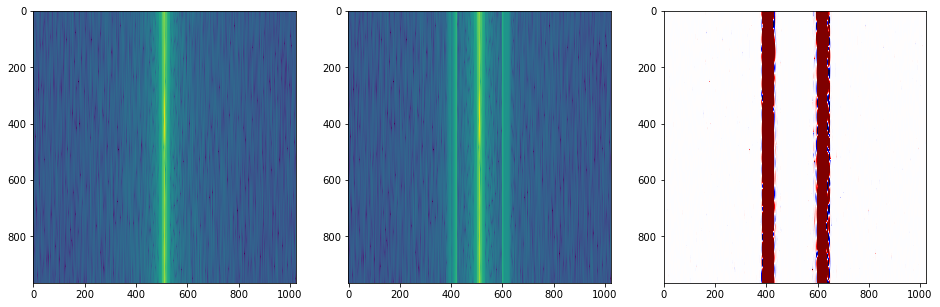

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
w = uvt.dspec.gen_window('bh', 1024)[None, :]
f1 = np.fft.fftshift(np.fft.fft(uv1.get_data(25, 26, 'xx')*w, axis=-1),axes=-1)
f2 = np.fft.fftshift(np.fft.fft(uv2.get_data(25, 26, 'xx')*w, axis=-1),axes=-1)
dlys = np.fft.fftfreq(uv1.Nfreqs, uv1.channel_width) * 1e9
axes[0].imshow(np.log10(np.abs(f1)), aspect='auto', vmin=-3, vmax=5)
axes[1].imshow(np.log10(np.abs(f2)), aspect='auto', vmin=-3, vmax=5)
axes[2].imshow(np.abs(f2)/np.abs(f1), aspect='auto', vmin=0.5, vmax=1.5, cmap='seismic')

__Figure 1__ | Simple plot showing true sum data (left) true sum + xtalk (center) and their ratio (right), showing that the added xtalk is localized in delay and slowly variable over time, as expected.